## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


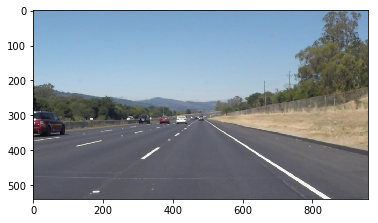

In [2]:
image_path = 'test_images/solidWhiteRight.jpg'
image = mpimg.imread(image_path)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices, draw=False, thickness=1):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    if draw:
        cv2.polylines(masked_image, vertices, False, (255, 0, 0), thickness)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def show_gray(img):
    plt.imshow(img, cmap='gray')
    
def save_image(img, path):
    cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
#----------------------------------------------------------------
def select_objects_above_thresholds(image, thresholds):
    color_select = np.copy(image)
    color_select[thresholds] = [0, 0, 0]
    return color_select
#----------------------------------------------------------------
def make_thresholds(image, rgb_threshold, channel_under=None):
    thresholds =   (image[:,:,0] < rgb_threshold[0]) \
                 | (image[:,:,1] < rgb_threshold[1]) \
                 | (image[:,:,2] < rgb_threshold[2])
            
    if channel_under is not None:
        thresholds |=   (channel_under[0] is not None and image[:,:,0] > channel_under[0]) \
                      | (channel_under[1] is not None and image[:,:,1] > channel_under[1]) \
                      | (channel_under[2] is not None and image[:,:,2] > channel_under[2])
    return thresholds

# Plan

1. Convert to grayscale
+ Use Blur
+ Use Canny to detect edges
+ Use Hough to detect lines
+ Use masking to leave only center lines
+ Use regression to regress to two solid lines.


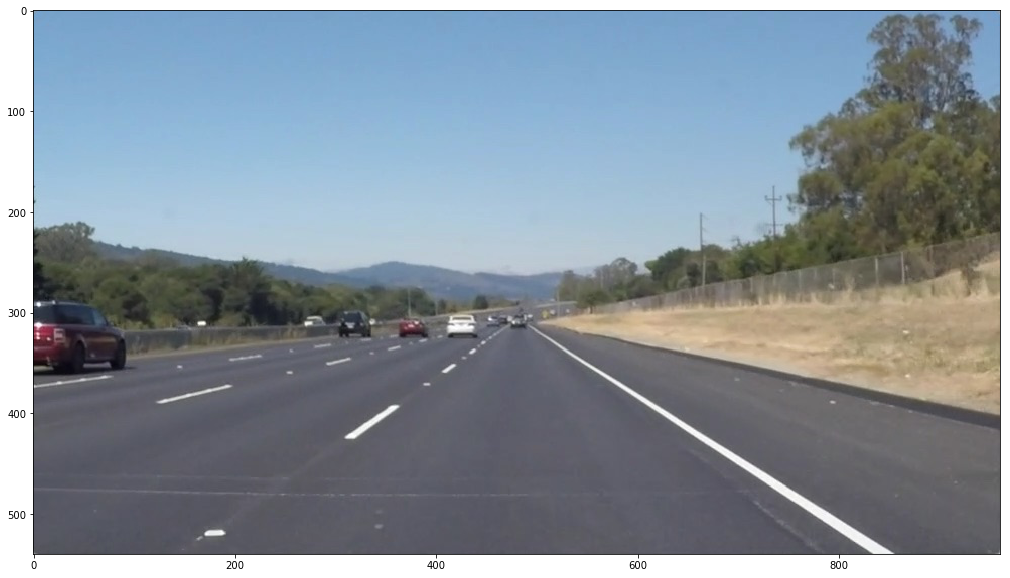

In [7]:
plt.rcParams["figure.figsize"] = (20,10)
source_image = image # mpimg.imread(image_path)
plt.imshow(source_image)

In [8]:
def select_yellow_and_white(source_image):
    yellow_t = make_thresholds(source_image, (150, 150, 0), (None, None, 100))
    white_t = make_thresholds(source_image, (200, 200, 200))
    final_t = yellow_t & white_t
    yellow_and_white_image = select_objects_above_thresholds(source_image, final_t)
    plt.imshow(yellow_and_white_image)
    return yellow_and_white_image

# yellow_and_white_image = select_yellow_and_white(source_image)
yellow_and_white_image = source_image

## 1. Grayscale

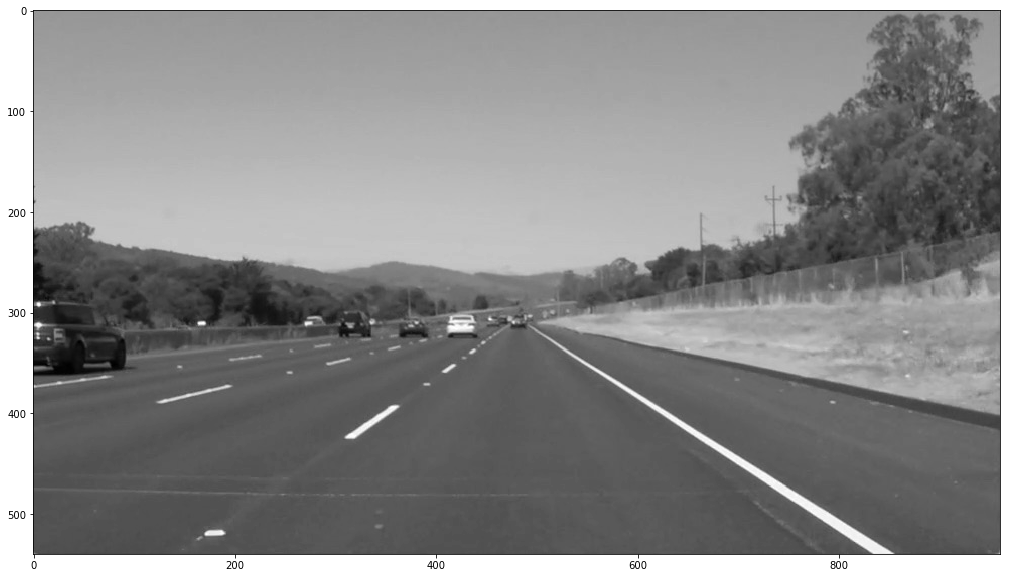

In [9]:
# source_image = mpimg.imread(image_path)
gray_image = grayscale(yellow_and_white_image)
plt.figure(figsize=(20,10))
plt.imshow(gray_image, cmap='gray')

# 2. Blur

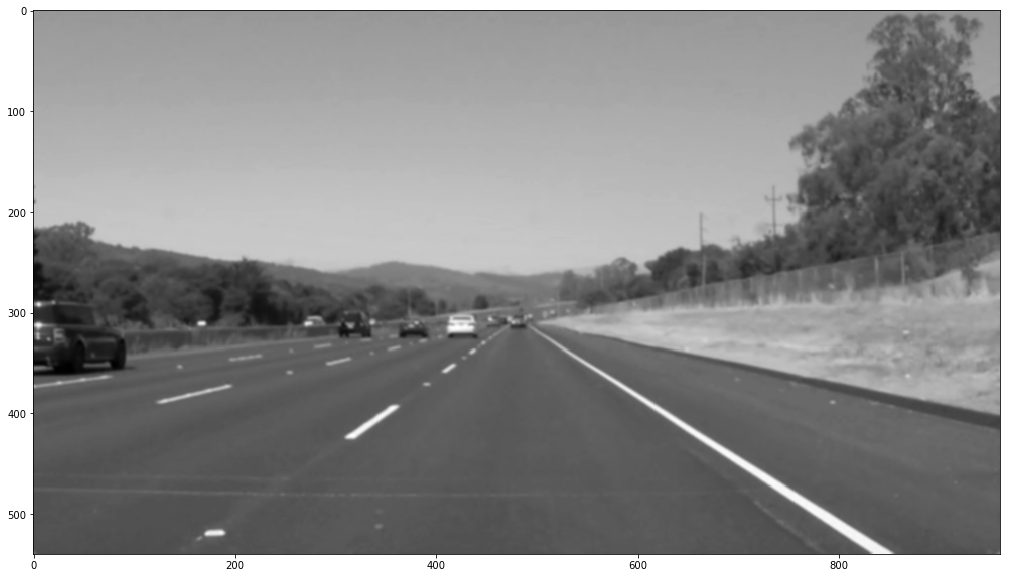

In [10]:
blurred_image = gaussian_blur(gray_image, 5)
plt.imshow(blurred_image, cmap='gray')

# 3. Canny to detect edges

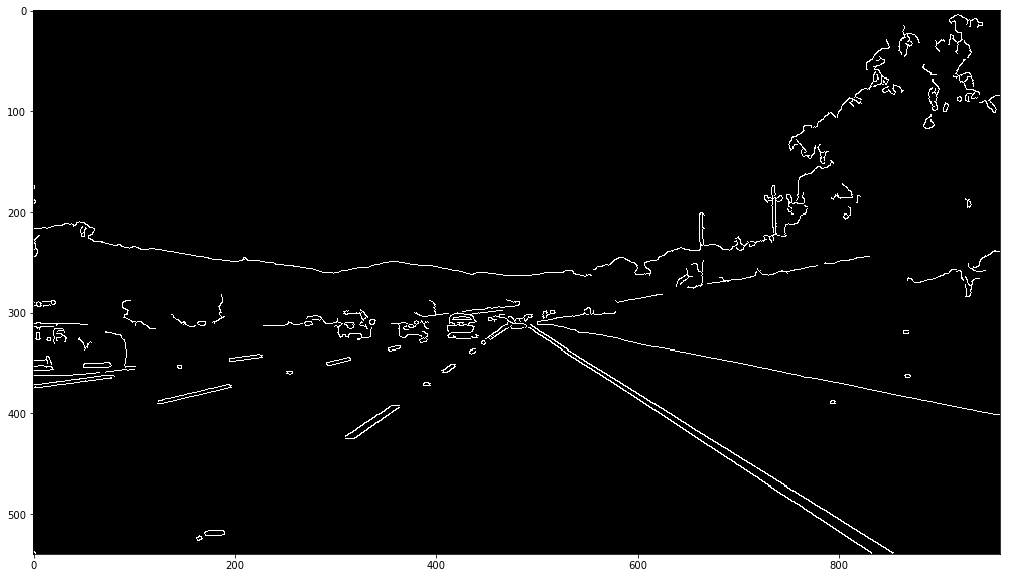

In [11]:
edges = canny(blurred_image, low_threshold=50, high_threshold=150)
show_gray(edges)

Demonstration how Canny edge detection works. The first image is half-white and half-blue rectangles. Canny edge detection will produce an image that is black everywhere, except for the transition area, which will be a white line.

(1127, 2002)


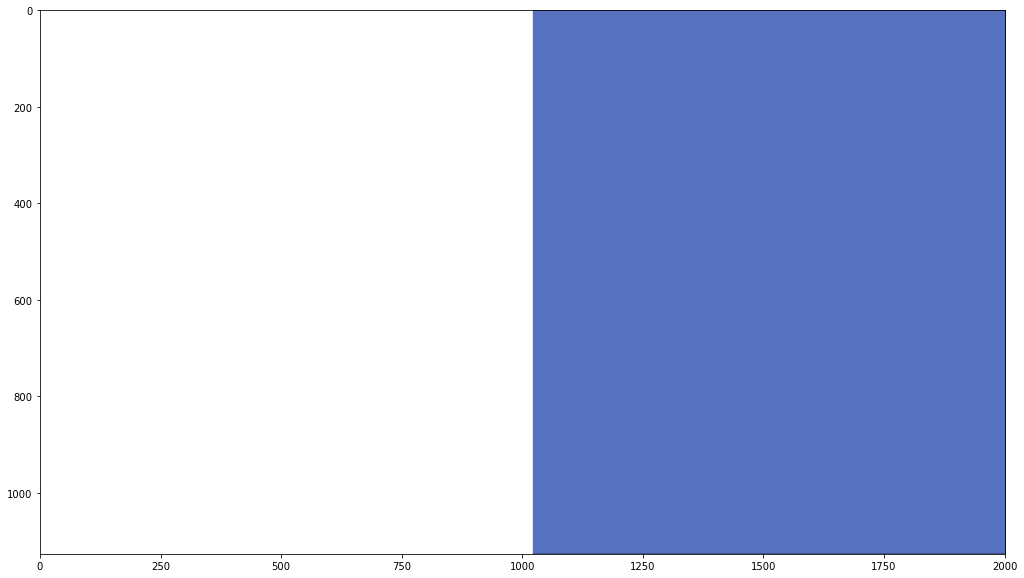

In [12]:
def to_canny(img_name):
    image_path = 'test_images/' + img_name
    image = mpimg.imread(image_path)
    plt.imshow(image)
    gray_image = grayscale(image)
    blurred_image = gaussian_blur(gray_image, 5)
    print(blurred_image.shape)
    edges = canny(blurred_image, low_threshold=10, high_threshold=10)
    return edges

edges1 = to_canny('canny-white-blue.jpg')

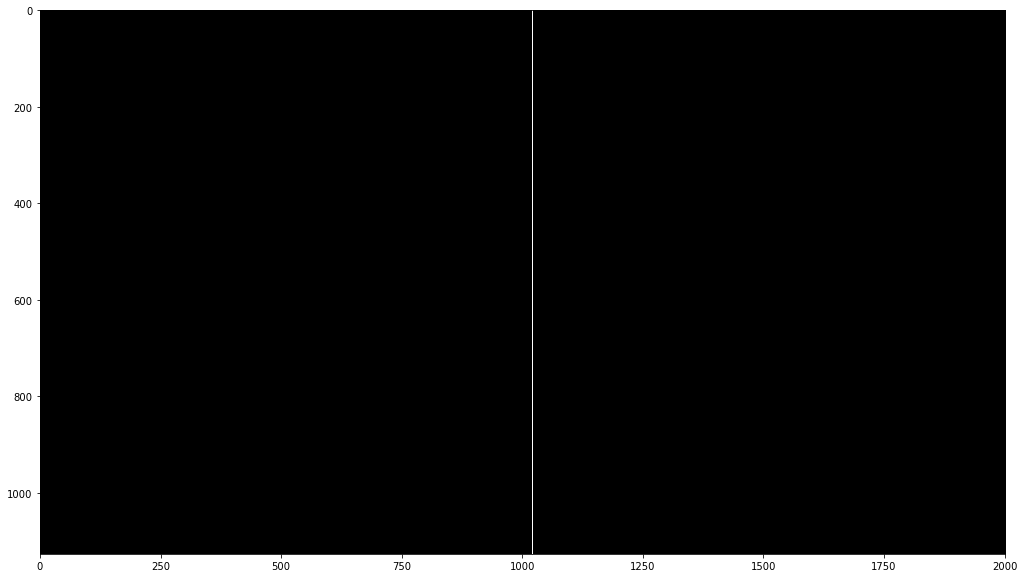

In [13]:
show_gray(edges1)

Colors of the regions don't matter. Any other color combination will produce the same result. Hence, Canny *edge* detection algorithm.

(1127, 2000)


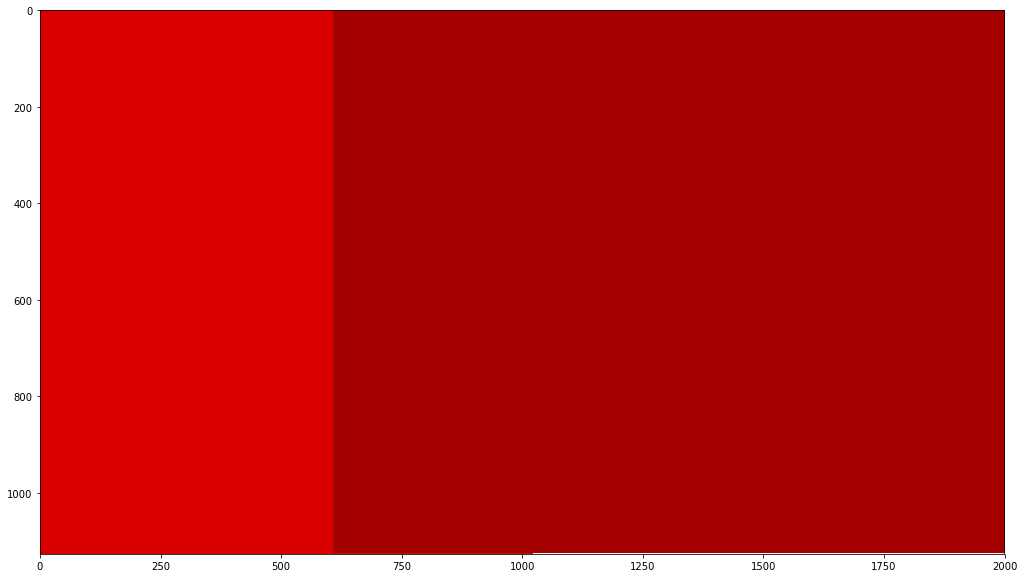

In [14]:
edges1 = to_canny('canny-red-red.jpg')

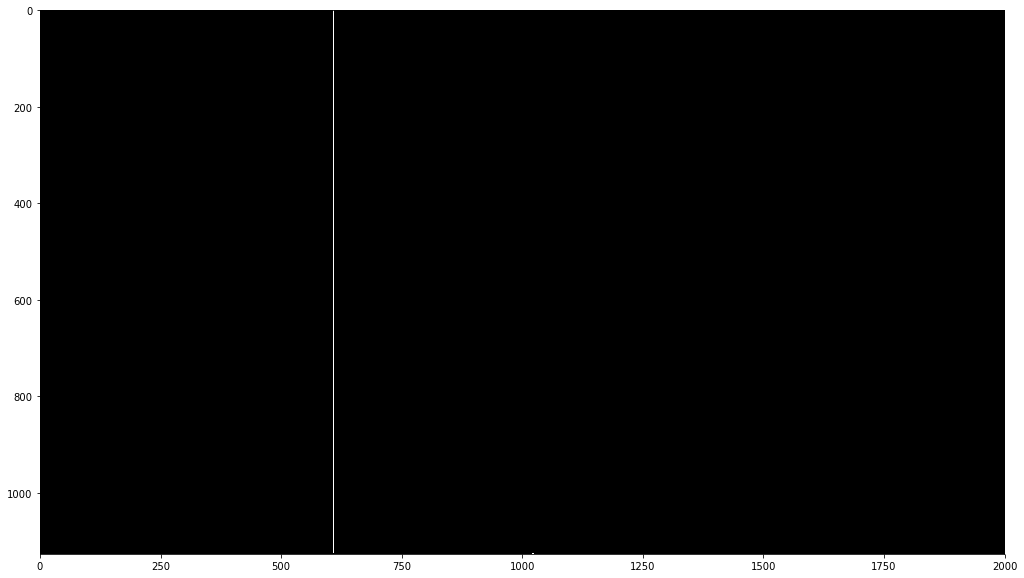

In [15]:
show_gray(edges1)

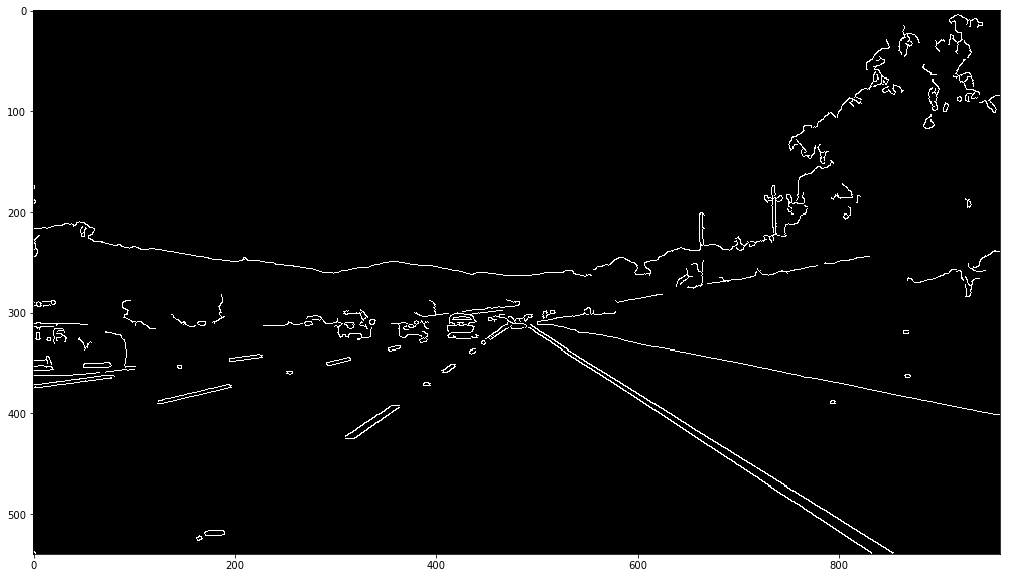

In [21]:
to_mask = edges.copy()
to_mask = to_mask.reshape(to_mask.shape[0], to_mask.shape[1], 1)
to_mask = np.repeat(to_mask.astype(np.uint8), 3, 2)
plt.imshow(to_mask)

# 5. Masking

In [45]:
h, w, _ = line_image.shape
vertical_ratio = .58

Display region of interest:

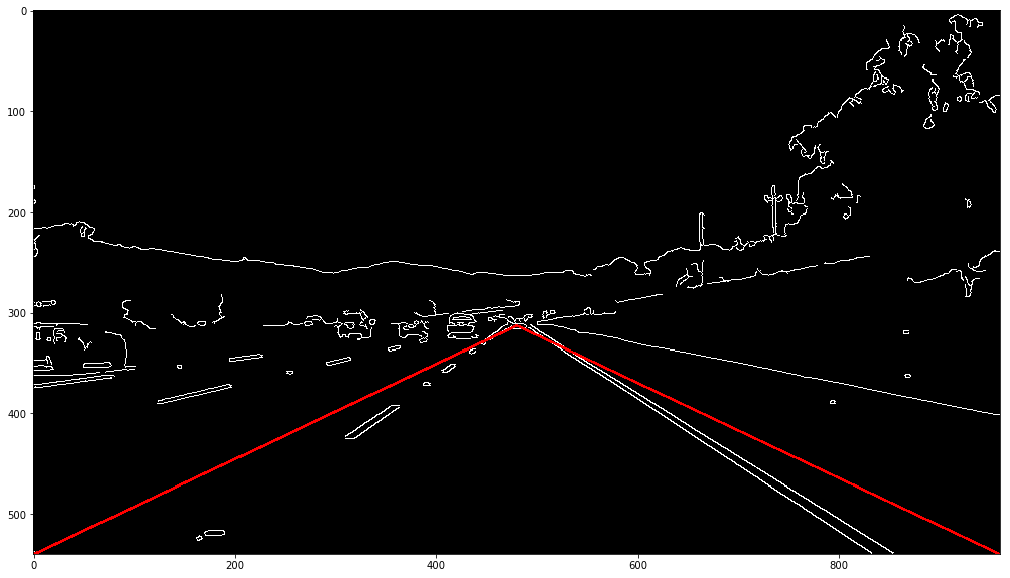

In [46]:
points = np.array([[ (0, h),
                (w * .5, h * vertical_ratio), 
                (w * .5, h * vertical_ratio), 
                (w, h) 
                ]], dtype=np.int32)

show_gray(cv2.polylines(to_mask.copy(), points, False, (255, 0, 0), 2))

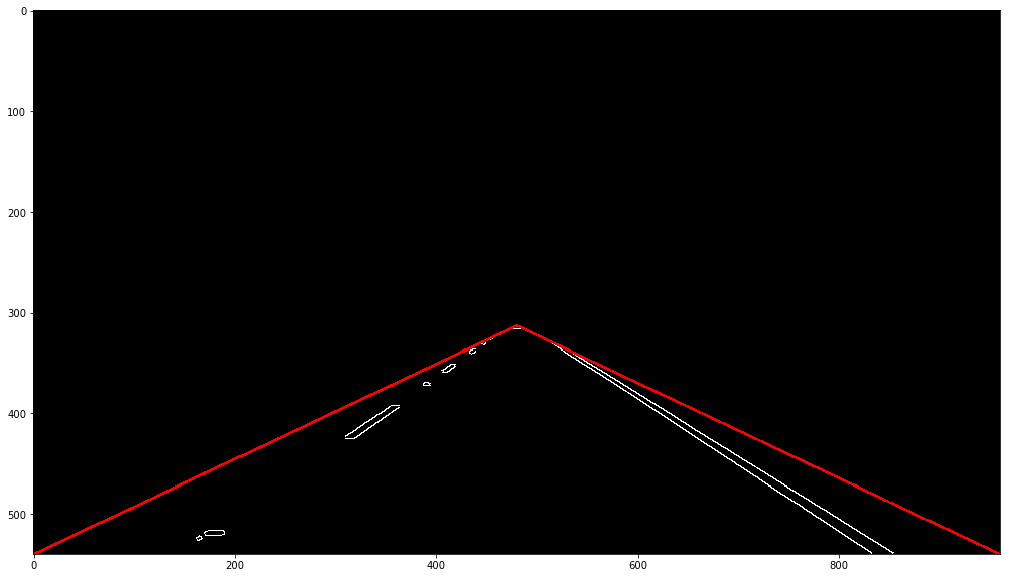

In [47]:
masked_image = region_of_interest(to_mask, points, True, 2)
show_gray(masked_image)

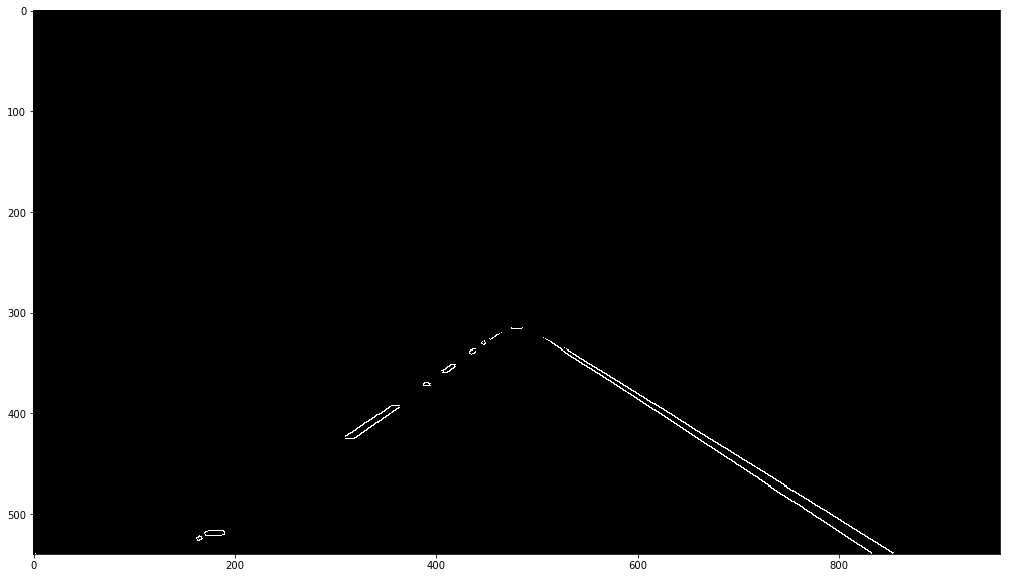

In [48]:
masked_image = region_of_interest(to_mask, points)
show_gray(masked_image)

# 6. Regression

Split line to the left and the right:

In [49]:
from sklearn.linear_model import LinearRegression 
#----------------------------------------------------------------
def X_y_from_line(line):
    X, y = [], []
    for x1, y1, x2, y2 in line:
        X.extend([[x1], [x2]])
        y.extend([[y1], [y2]])
    return X, y

#----------------------------------------------------------------
#
# Main function is detect_lanes() below.
#
#----------------------------------------------------------------
def select_lines_in_half(image, min_x, max_x):
    lines = cv2.HoughLinesP(grayscale(image), 
                            1, 
                            np.pi/180, 
                            1, 
                            np.array([]), 
                            1, 
                            1)
    result_lines = []
    X = []
    y = []
    for line in lines:
        this_line = []
        
        for x1, y1, x2, y2 in line:
            # if both points in the half, use it
            if min_x <= x1 < max_x and min_x <= x2 < max_x:
                this_line.append((x1, y1, x2, y2))
        
        if len(this_line) > 0:
            result_lines.append(np.array(this_line))
            this_X, this_y = X_y_from_line(this_line)
            X.extend(this_X)
            y.extend(this_y)
            
    return np.array(result_lines), \
           np.array(X).reshape(-1, 1),  \
           np.array(y).reshape(-1, 1)
#----------------------------------------------------------------    
def regress_line(img, min_x, max_x, vertical_ratio):
    h, w = img.shape[:2]
    lines, X, y = select_lines_in_half(img, min_x, max_x)
    
    if len(lines) > 0:
        reg = LinearRegression()
        # We will flip X and y. We want to draw the line to the
        # bottom of the screen—that's y = h - 1, so we want to find
        # X that corresponds to y.
        reg.fit(y, X)
        y1, y2 = h - 1, int(h * vertical_ratio)
        x1, x2 = tuple(reg.predict(np.array([y1, y2]).reshape(-1, 1)))
        return (x1, y1, x2, y2), lines
    else:
        return None, None


Process left and right halves independently:

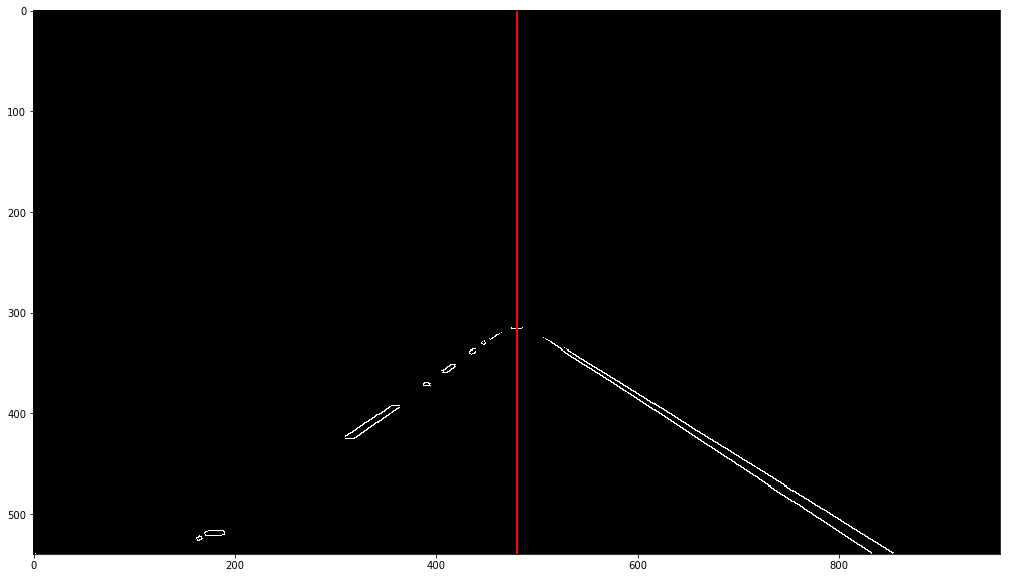

In [50]:
show_gray(cv2.line(masked_image.copy(), (int(0.5*w), 0), (int(0.5*w), h), (255, 0, 0)))

Select a line:

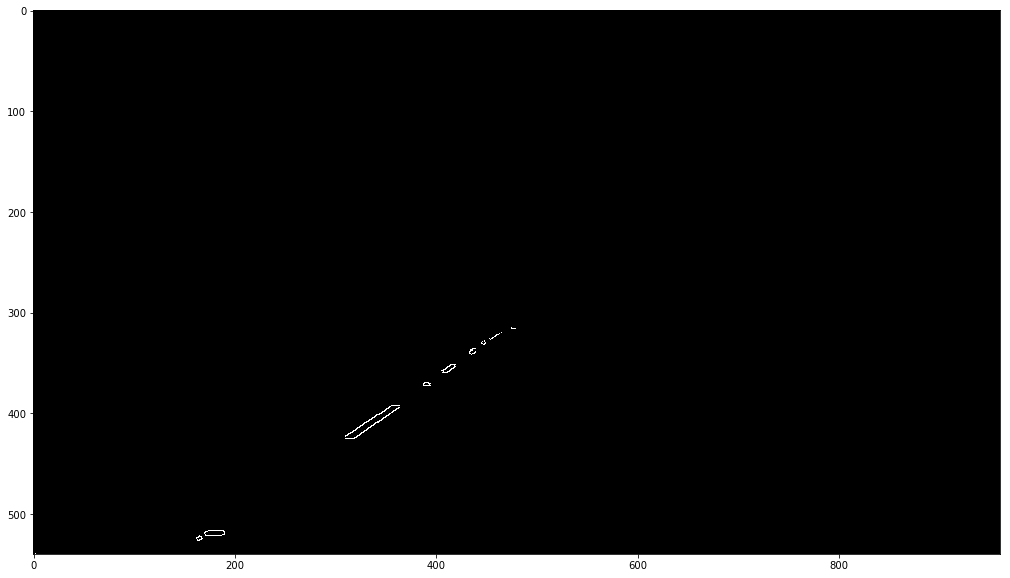

In [51]:
half_image = cv2.fillPoly(masked_image.copy(), 
             np.array([[(int(w/2.), 0), (w, 0), (w, h), (int(w/2.), h)]]),
             (0, 0, 0))
plt.imshow(half_image)

In [29]:
def draw_regressed_lines(regressed_image, left, right):
    draw_lines(regressed_image, [[left]], (255, 0, 0), 3)
    if right:
        draw_lines(regressed_image, [[right]], (255, 0, 0), 3)
    plt.imshow(regressed_image)

(array([ 147.64841402]), 539, array([ 434.02656843]), 340)


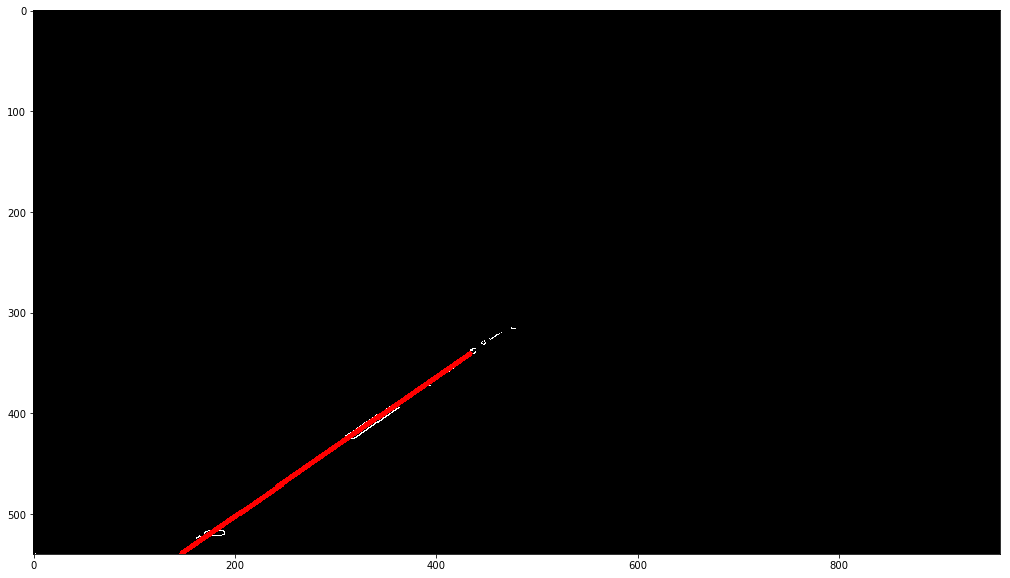

In [53]:
line_draw_vert_ratio = 0.63
reg_image = half_image.copy()
left, left_lines = regress_line(reg_image, 0, 0.5*w, line_draw_vert_ratio)
print(left)
# draw_lines(reg_image, left_lines, (255, 0, 0), 1)
draw_regressed_lines(reg_image, left, None)
plt.imshow(reg_image)

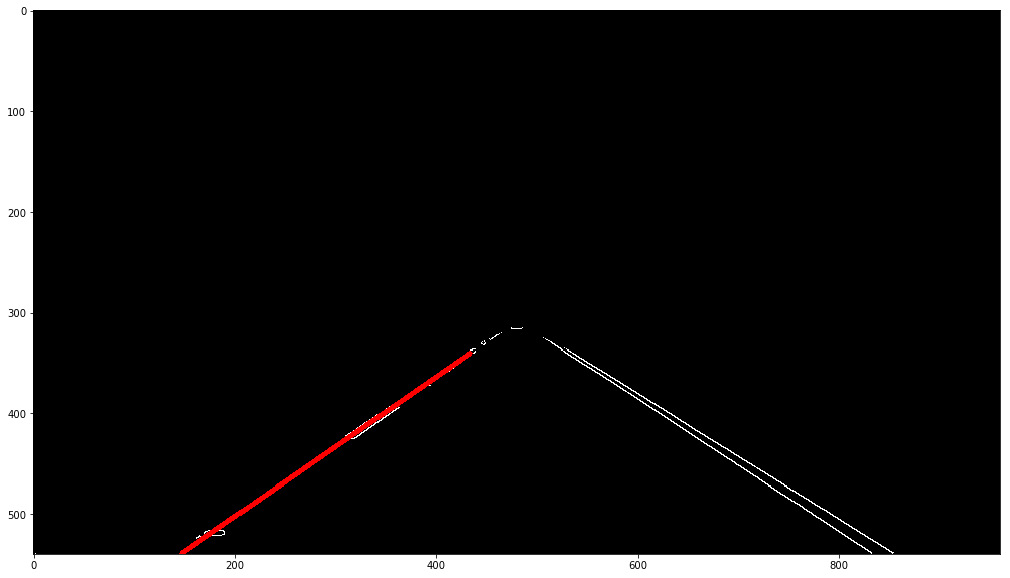

In [54]:
plt.show(draw_regressed_lines(masked_image.copy(), left, None))

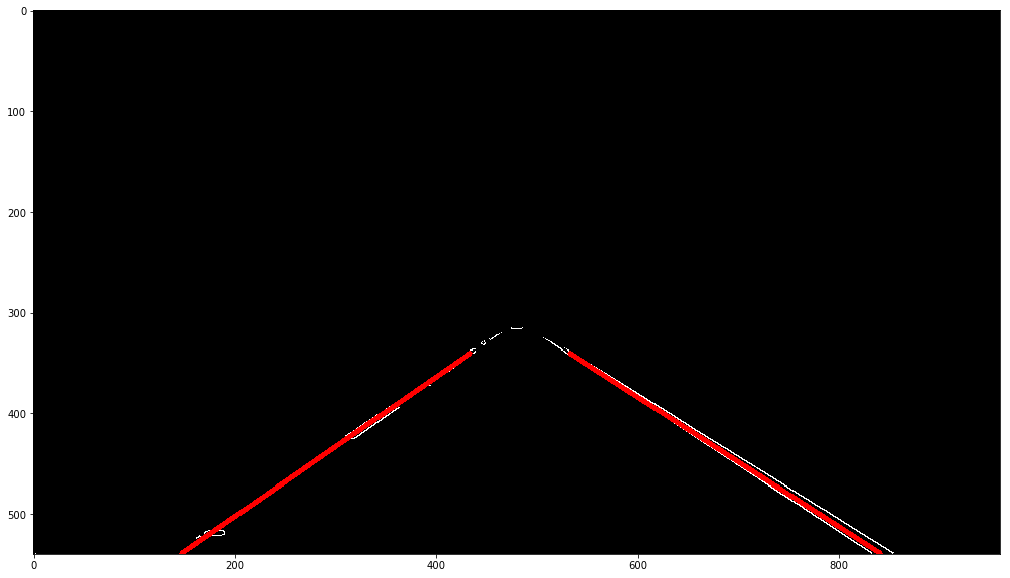

In [55]:
regressed_image_2 = np.copy(masked_image)
right, right_lines = regress_line(masked_image, 0.5*w, w, line_draw_vert_ratio)
draw_regressed_lines(regressed_image_2, left, right)

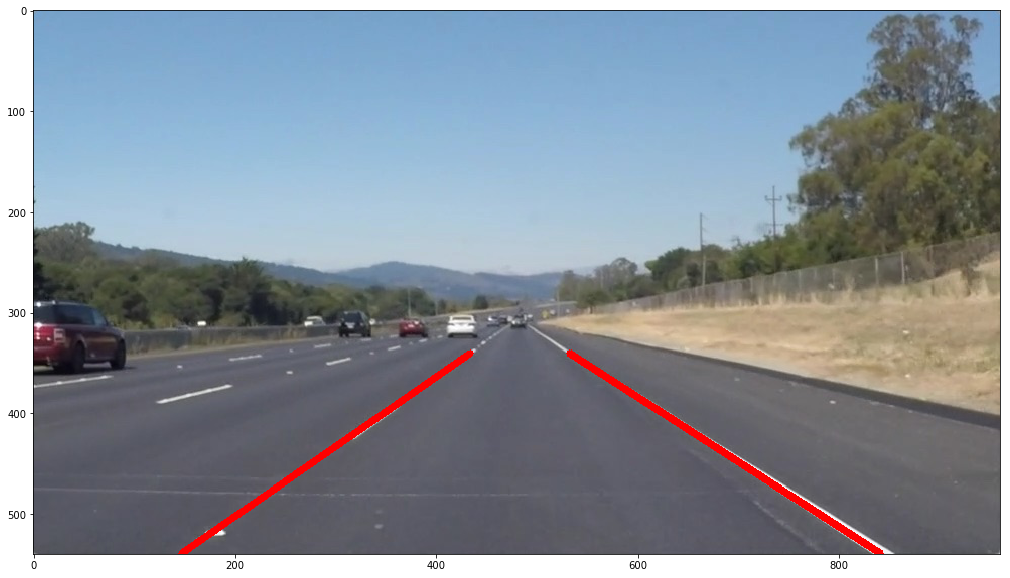

In [56]:
final_image = np.copy(image)
draw_lines(final_image, [[left], [right]], (255, 0, 0), 5)
plt.imshow(final_image)


# Full pipeline

In [64]:
#----------------------------------------------------------------
def detect_lanes(src_image):
    _yellow_t = make_thresholds(src_image, (150, 150, 0), (None, None, 100))
    _white_t = make_thresholds(src_image, (200, 200, 200))
    _final_t = _yellow_t & _white_t
    _yellow_and_white_image = select_objects_above_thresholds(src_image, _final_t)
    
    _gray_image = grayscale(_yellow_and_white_image)
    _blurred_image = gaussian_blur(_gray_image, 5)
    _edges = canny(_blurred_image, low_threshold=50, high_threshold=150)
    _line_image, _lines = hough_lines(_edges, 
                         rho=1, 
                         theta=np.pi/180, 
                         threshold=1, 
                         min_line_len=5, 
                         max_line_gap=1)

    # Masking
    h, w, _ = _line_image.shape
    vertical_ratio = .58
    _masked_image = region_of_interest(
        _line_image, 
        np.array([[ (0, h),
                (w * .5, h * vertical_ratio), 
                (w * .5, h * vertical_ratio), 
                (w, h) 
                ]], dtype=np.int32))
    
    # Regression
    _left, _left_lines = regress_line(_masked_image, 0, 0.5*w, 0.63)
    _right, _right_lines = regress_line(_masked_image, 0.5*w, w, 0.63)
    line_color = (255, 0, 0)
    
    # Final line drawing
    lines_to_draw = []
    if _left:
        lines_to_draw.append([_left])
    if _right:
        lines_to_draw.append([_right])
        
    draw_lines(src_image, lines_to_draw, line_color, 5)
    draw_lines(_edges, lines_to_draw, line_color, 5)
    
    return src_image

In [65]:
import os
from os import path

def main():
    dirname = "test_images/"
    names = os.listdir(dirname)
    for name in names:
        if not 'lanes' in name:
            print(name)
            image_path = dirname + name
            image = detect_lanes(mpimg.imread(image_path))
            # We need to adjust RGB to BGR, or the image is saved incorrectly
            cv2.imwrite(dirname + 'lanes-' + name, 
                        cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
# main()

## Test on Videos

Note that there's a glitch in the version of the library that I have—it feeds the output of the first frame back as a source, so I end up with double lines as shown below. The rest of the frames are fine. These only appear on the preview image. The video itself looks good. 

You may not experience this issue with your version of moviepy.

[frame 1]: ./examples/glitch-in-moviepy/output-1.jpg " "
[frame 2]: ./examples/glitch-in-moviepy/output-2.jpg " "
[frame 3]: ./examples/glitch-in-moviepy/output-3.jpg " "

| Output Frame 1 | Output Frame 2 |  Output Frame 3 |
|----------|----------|----------|
|![frame 1]|![frame 2]|![frame 3]|


In [66]:
image_count = 0

In [67]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global image_count
    
    result = detect_lanes(image) if image_count > 0 else image
    image_count += 1
    
    return result

In [68]:
white_output = 'white.mp4'

In [69]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [70]:
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:14<00:00, 14.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 12.3 s, sys: 2.51 s, total: 14.8 s
Wall time: 15.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [71]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))